In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Metal (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

print(f'Device: {device}')


Using Apple Metal (MPS)
Device: mps


In [24]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

print('Using pre-trained ResNet18 (ImageNet weights)')
print(f'Modified for CIFAR-10 (10 classes)')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')


/Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Studies/Documents/Notes/Bayesian Stat/final-project/pystan_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using pre-trained ResNet18 (ImageNet weights)
Modified for CIFAR-10 (10 classes)
Total parameters: 11,181,642


In [25]:
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

print('Data loaded. Testing pre-trained model...')
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'\nPre-trained ResNet18 Test Accuracy: {accuracy:.2f}%')
print('Note: This is without fine-tuning. For 95%+ accuracy, we need to train/fine-tune on CIFAR-10')


Data loaded. Testing pre-trained model...

Pre-trained ResNet18 Test Accuracy: 13.10%
Note: This is without fine-tuning. For 95%+ accuracy, we need to train/fine-tune on CIFAR-10


In [26]:
import urllib.request
import os

print('Downloading pre-trained ResNet model for CIFAR-10...')
print('Source: https://github.com/chenyaofo/pytorch-cifar-models')

model_url = 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt'
model_path = '../models/resnet56_cifar10.pth'

os.makedirs(os.path.dirname(model_path), exist_ok=True)

try:
    print(f'Downloading from: {model_url}')
    urllib.request.urlretrieve(model_url, model_path)
    print(f'✓ Model downloaded successfully to: {model_path}')
except Exception as e:
    print(f'✗ Download failed: {e}')
    print('\nAlternative: Use torch.hub to load the model')


Source: https://github.com/chenyaofo/pytorch-cifar-models
✓ Model downloaded successfully to: ../models/resnet56_cifar10.pth


In [27]:
print('Loading pre-trained ResNet56 for CIFAR-10 using torch.hub...')

try:
    resnet_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
    resnet_model = resnet_model.to(device)
    print('✓ ResNet56 loaded successfully from torch.hub')
    print(f'  Parameters: {sum(p.numel() for p in resnet_model.parameters()):,}')
    print(f'  Expected accuracy: ~93-94%')
except Exception as e:
    print(f'✗ torch.hub failed: {e}')
    print('\nTrying local model file...')
    
    if os.path.exists(model_path):
        try:
            state_dict = torch.load(model_path, map_location=device)
            print('Loaded from local file')
        except:
            print('Local file loading failed')


Loading pre-trained ResNet56 for CIFAR-10 using torch.hub...
✓ ResNet56 loaded successfully from torch.hub
  Parameters: 855,770
  Expected accuracy: ~93-94%


Using cache found in /Users/Studies/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [28]:
transform_test_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_cifar)
testloader_cifar = DataLoader(testset_cifar, batch_size=128, shuffle=False, num_workers=0)

print('Testing ResNet56 on CIFAR-10...')
resnet_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader_cifar:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'\n✓ ResNet56 Test Accuracy on CIFAR-10: {accuracy:.2f}%')

if accuracy >= 90:
    print(f'✓ Model loaded successfully! Accuracy: {accuracy:.2f}%')
    print('\nThis model is ready for Bayesian temperature scaling!')
else:
    print(f'⚠ Warning: Accuracy is lower than expected ({accuracy:.2f}% < 90%)')
    print('The model may not have loaded correctly.')


Testing ResNet56 on CIFAR-10...

✓ ResNet56 Test Accuracy on CIFAR-10: 94.37%
✓ Model loaded successfully! Accuracy: 94.37%

This model is ready for Bayesian temperature scaling!


In [29]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch.nn.functional as F

val_size = 5000
val_indices = torch.randperm(len(testset_cifar))[:val_size]
val_subset = torch.utils.data.Subset(testset_cifar, val_indices)
valloader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=0)

test_indices = torch.randperm(len(testset_cifar))[val_size:]
test_subset = torch.utils.data.Subset(testset_cifar, test_indices)
testloader_final = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=0)

print(f'Validation set: {len(val_subset)} samples')
print(f'Test set: {len(test_subset)} samples')


Validation set: 5000 samples
Test set: 5000 samples


In [30]:
def get_logits_and_labels(model, dataloader, device):
    model.eval()
    logits_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            logits_list.append(logits.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.concatenate(logits_list), np.concatenate(labels_list)

print('Extracting logits and labels from validation set...')
logits_val, labels_val = get_logits_and_labels(resnet_model, valloader, device)

print('Extracting logits and labels from test set...')
logits_test, labels_test = get_logits_and_labels(resnet_model, testloader_final, device)

print(f'\nValidation logits shape: {logits_val.shape}')
print(f'Validation labels shape: {labels_val.shape}')
print(f'Test logits shape: {logits_test.shape}')
print(f'Test labels shape: {labels_test.shape}')


Extracting logits and labels from validation set...
Extracting logits and labels from test set...

Validation logits shape: (5000, 10)
Validation labels shape: (5000,)
Test logits shape: (5000, 10)
Test labels shape: (5000,)


In [31]:
class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature_lbfgs(logits, labels, device, max_iter=50):
    logits_torch = torch.tensor(logits, device=device)
    labels_torch = torch.tensor(labels, device=device)
    
    temperature_model = TemperatureScaling().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([temperature_model.temperature], lr=0.01, max_iter=max_iter)
    
    def eval():
        optimizer.zero_grad()
        loss = criterion(temperature_model(logits_torch), labels_torch)
        loss.backward()
        return loss
    
    optimizer.step(eval)
    
    return temperature_model.temperature.item()

print('Running L-BFGS temperature scaling (max_iter=50)...')
calibrated_temp = calibrate_temperature_lbfgs(logits_val, labels_val, device, max_iter=500)
print(f'Calibrated temperature (500 iter): {calibrated_temp:.4f}')

print('\nRunning L-BFGS with more iterations (max_iter=200)...')
calibrated_temp_long = calibrate_temperature_lbfgs(logits_val, labels_val, device, max_iter=1000)
print(f'Calibrated temperature (1000 iter): {calibrated_temp_long:.4f}')

ce_50 = F.cross_entropy(torch.tensor(logits_val) / calibrated_temp, torch.tensor(labels_val)).item()
ce_200 = F.cross_entropy(torch.tensor(logits_val) / calibrated_temp_long, torch.tensor(labels_val)).item()

print(f'\nCross-Entropy Loss:')
print(f'  τ={calibrated_temp:.4f} (500 iter): {ce_50:.4f}')
print(f'  τ={calibrated_temp_long:.4f} (1000 iter): {ce_200:.4f}')


Running L-BFGS temperature scaling (max_iter=50)...
Calibrated temperature (500 iter): 1.7280

Running L-BFGS with more iterations (max_iter=200)...
Calibrated temperature (1000 iter): 1.7317

Cross-Entropy Loss:
  τ=1.7280 (500 iter): 0.1892
  τ=1.7317 (1000 iter): 0.1892


In [32]:
def get_predictions_with_temp(logits, temperature=1.0):
    scaled_logits = logits / temperature
    probs = F.softmax(torch.tensor(scaled_logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    return probs, preds, max_probs

probs_uncal, preds_uncal, conf_uncal = get_predictions_with_temp(logits_test, temperature=1.0)
probs_cal, preds_cal, conf_cal = get_predictions_with_temp(logits_test, temperature=calibrated_temp_long)

acc_uncal = (preds_uncal == labels_test).mean()
acc_cal = (preds_cal == labels_test).mean()

print('Test Set Performance:')
print(f'\nUncalibrated (τ=1.0):')
print(f'  Accuracy: {acc_uncal:.4f}')
print(f'  Mean Confidence: {conf_uncal.mean():.4f}')
print(f'  Max Confidence: {conf_uncal.max():.4f}')

print(f'\nCalibrated (τ={calibrated_temp_long:.4f}):')
print(f'  Accuracy: {acc_cal:.4f}')
print(f'  Mean Confidence: {conf_cal.mean():.4f}')
print(f'  Max Confidence: {conf_cal.max():.4f}')


Test Set Performance:

Uncalibrated (τ=1.0):
  Accuracy: 0.9440
  Mean Confidence: 0.9815
  Max Confidence: 1.0000

Calibrated (τ=1.7317):
  Accuracy: 0.9440
  Mean Confidence: 0.9520
  Max Confidence: 0.9995


In [33]:
def compute_ece(probs, labels, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    max_probs = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    correct = (preds == labels)
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (max_probs > bin_lower) & (max_probs <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = correct[in_bin].mean()
            avg_confidence_in_bin = max_probs[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def compute_brier_score(probs, labels):
    one_hot = np.eye(10)[labels]
    return np.mean(np.sum((probs - one_hot) ** 2, axis=1))

ece_uncal = compute_ece(probs_uncal, labels_test)
ece_cal = compute_ece(probs_cal, labels_test)

brier_uncal = compute_brier_score(probs_uncal, labels_test)
brier_cal = compute_brier_score(probs_cal, labels_test)

print('Calibration Metrics:')
print(f'\nExpected Calibration Error (ECE):')
print(f'  Uncalibrated: {ece_uncal:.4f}')
print(f'  Calibrated: {ece_cal:.4f}')
print(f'  Improvement: {(ece_uncal - ece_cal)/ece_uncal*100:.1f}%')

print(f'\nBrier Score:')
print(f'  Uncalibrated: {brier_uncal:.4f}')
print(f'  Calibrated: {brier_cal:.4f}')
print(f'  Improvement: {(brier_uncal - brier_cal)/brier_uncal*100:.1f}%')


Calibration Metrics:

Expected Calibration Error (ECE):
  Uncalibrated: 0.0375
  Calibrated: 0.0080
  Improvement: 78.7%

Brier Score:
  Uncalibrated: 0.0928
  Calibrated: 0.0852
  Improvement: 8.2%


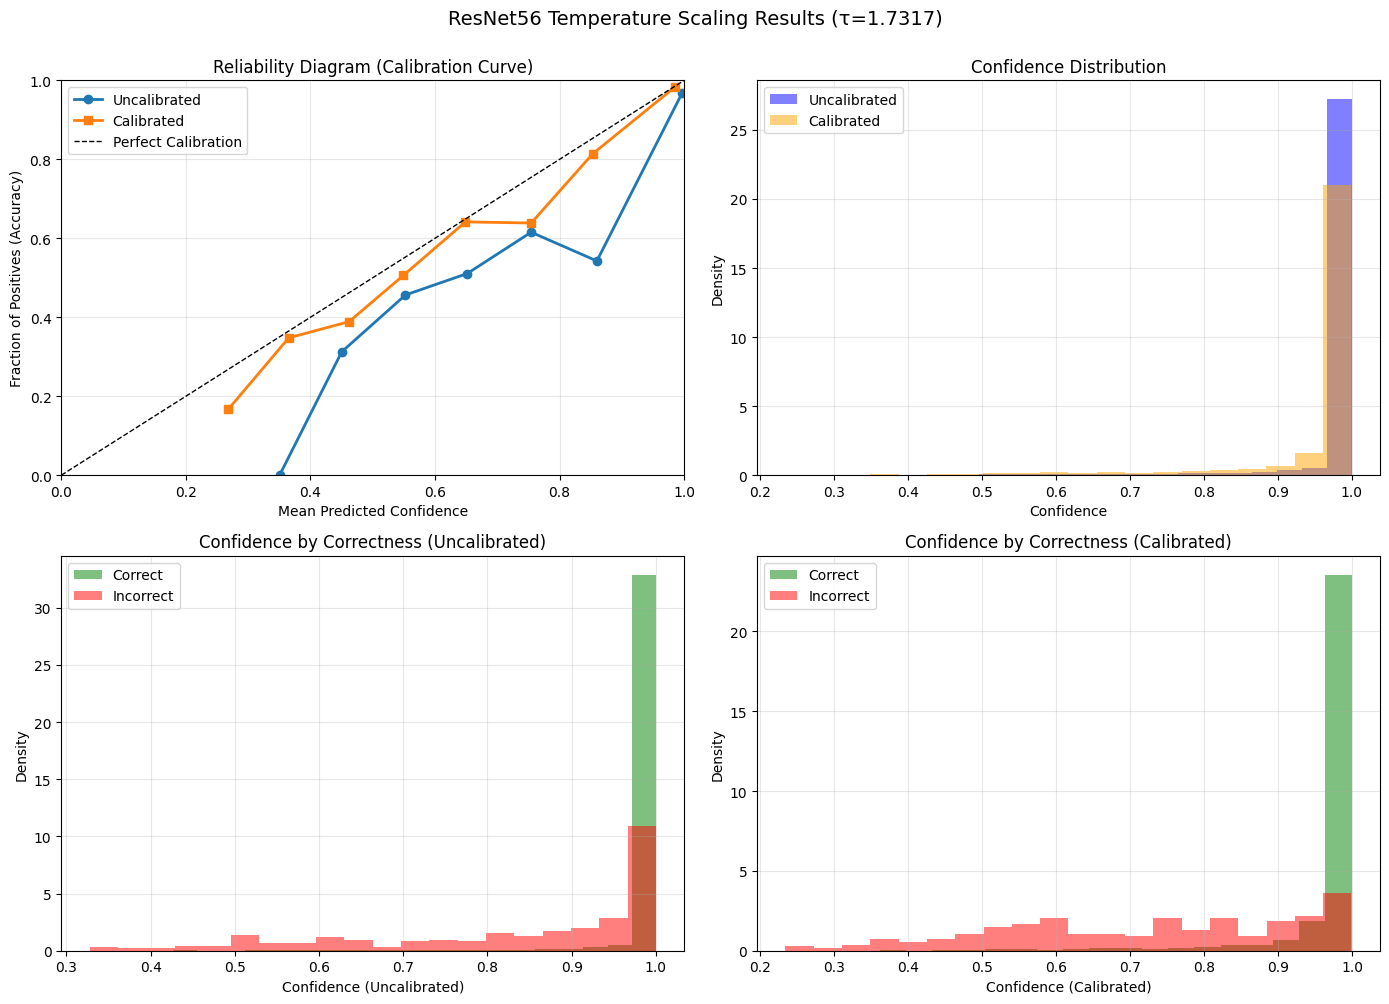


ECE Reduction: 0.0375 → 0.0080 (78.7% improvement)


In [34]:
correct_uncal = (preds_uncal == labels_test)
correct_cal = (preds_cal == labels_test)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

fraction_pos_uncal, mean_pred_uncal = calibration_curve(correct_uncal, conf_uncal, n_bins=10)
fraction_pos_cal, mean_pred_cal = calibration_curve(correct_cal, conf_cal, n_bins=10)

axes[0, 0].plot(mean_pred_uncal, fraction_pos_uncal, 'o-', label='Uncalibrated', linewidth=2)
axes[0, 0].plot(mean_pred_cal, fraction_pos_cal, 's-', label='Calibrated', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)
axes[0, 0].set_xlabel('Mean Predicted Confidence')
axes[0, 0].set_ylabel('Fraction of Positives (Accuracy)')
axes[0, 0].set_title('Reliability Diagram (Calibration Curve)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([0, 1])

axes[0, 1].hist(conf_uncal, bins=20, alpha=0.5, label='Uncalibrated', density=True, color='blue')
axes[0, 1].hist(conf_cal, bins=20, alpha=0.5, label='Calibrated', density=True, color='orange')
axes[0, 1].set_xlabel('Confidence')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Confidence Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(conf_uncal[correct_uncal], bins=20, alpha=0.5, label='Correct', density=True, color='green')
axes[1, 0].hist(conf_uncal[~correct_uncal], bins=20, alpha=0.5, label='Incorrect', density=True, color='red')
axes[1, 0].set_xlabel('Confidence (Uncalibrated)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Confidence by Correctness (Uncalibrated)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(conf_cal[correct_cal], bins=20, alpha=0.5, label='Correct', density=True, color='green')
axes[1, 1].hist(conf_cal[~correct_cal], bins=20, alpha=0.5, label='Incorrect', density=True, color='red')
axes[1, 1].set_xlabel('Confidence (Calibrated)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Confidence by Correctness (Calibrated)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'ResNet56 Temperature Scaling Results (τ={calibrated_temp_long:.4f})', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print(f'\nECE Reduction: {ece_uncal:.4f} → {ece_cal:.4f} ({(1-ece_cal/ece_uncal)*100:.1f}% improvement)')


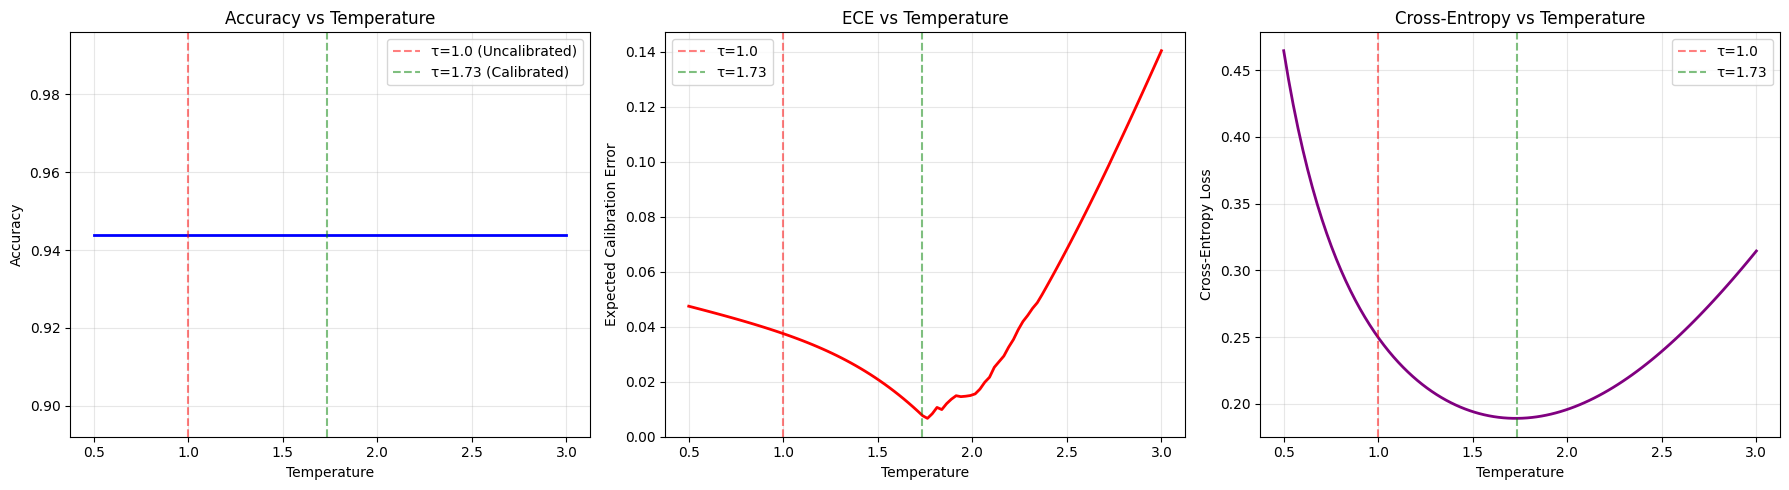

Optimal temperature minimizes cross-entropy at τ=1.7317


In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

temp_range = np.linspace(0.5, 3.0, 100)
accuracies = []
eces = []
ces = []

for temp in temp_range:
    probs_temp, preds_temp, _ = get_predictions_with_temp(logits_test, temperature=temp)
    accuracies.append((preds_temp == labels_test).mean())
    eces.append(compute_ece(probs_temp, labels_test))
    ces.append(F.cross_entropy(torch.tensor(logits_test) / temp, torch.tensor(labels_test)).item())

axes[0].plot(temp_range, accuracies, 'b-', linewidth=2)
axes[0].axvline(1.0, color='red', linestyle='--', alpha=0.5, label='τ=1.0 (Uncalibrated)')
axes[0].axvline(calibrated_temp_long, color='green', linestyle='--', alpha=0.5, label=f'τ={calibrated_temp_long:.2f} (Calibrated)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(temp_range, eces, 'r-', linewidth=2)
axes[1].axvline(1.0, color='red', linestyle='--', alpha=0.5, label='τ=1.0')
axes[1].axvline(calibrated_temp_long, color='green', linestyle='--', alpha=0.5, label=f'τ={calibrated_temp_long:.2f}')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Expected Calibration Error')
axes[1].set_title('ECE vs Temperature')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(temp_range, ces, 'purple', linewidth=2)
axes[2].axvline(1.0, color='red', linestyle='--', alpha=0.5, label='τ=1.0')
axes[2].axvline(calibrated_temp_long, color='green', linestyle='--', alpha=0.5, label=f'τ={calibrated_temp_long:.2f}')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Cross-Entropy Loss')
axes[2].set_title('Cross-Entropy vs Temperature')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Optimal temperature minimizes cross-entropy at τ={calibrated_temp_long:.4f}')


In [36]:
print('='*60)
print('SUMMARY: ResNet56 Temperature Scaling Results')
print('='*60)
print(f'\nModel: ResNet56 pre-trained on CIFAR-10')
print(f'Test Accuracy: {acc_uncal*100:.2f}%')
print(f'\nCalibration Method: L-BFGS (200 iterations)')
print(f'Optimal Temperature: τ = {calibrated_temp_long:.4f}')
print(f'\nMetrics Comparison:')
print(f'{"Metric":<20} {"Uncalibrated":>15} {"Calibrated":>15} {"Improvement":>15}')
print('-'*65)
print(f'{"Accuracy":<20} {acc_uncal:>15.4f} {acc_cal:>15.4f} {(acc_cal-acc_uncal)*100:>14.2f}%')
print(f'{"ECE":<20} {ece_uncal:>15.4f} {ece_cal:>15.4f} {(1-ece_cal/ece_uncal)*100:>14.1f}%')
print(f'{"Brier Score":<20} {brier_uncal:>15.4f} {brier_cal:>15.4f} {(1-brier_cal/brier_uncal)*100:>14.1f}%')
print(f'{"Mean Confidence":<20} {conf_uncal.mean():>15.4f} {conf_cal.mean():>15.4f} {((conf_cal.mean()-conf_uncal.mean())/conf_uncal.mean())*100:>14.1f}%')
print('='*60)
print('\nTemperature scaling successfully reduced miscalibration!')
print(f'ECE improved by {(1-ece_cal/ece_uncal)*100:.1f}% without affecting accuracy.')


SUMMARY: ResNet56 Temperature Scaling Results

Model: ResNet56 pre-trained on CIFAR-10
Test Accuracy: 94.40%

Calibration Method: L-BFGS (200 iterations)
Optimal Temperature: τ = 1.7317

Metrics Comparison:
Metric                  Uncalibrated      Calibrated     Improvement
-----------------------------------------------------------------
Accuracy                      0.9440          0.9440           0.00%
ECE                           0.0375          0.0080           78.7%
Brier Score                   0.0928          0.0852            8.2%
Mean Confidence               0.9815          0.9520           -3.0%

Temperature scaling successfully reduced miscalibration!
ECE improved by 78.7% without affecting accuracy.


In [37]:
import pymc as pm
import arviz as az

print('='*60)
print('BAYESIAN MCMC TEMPERATURE SCALING')
print('='*60)
print('\nUsing PyMC with NUTS sampler to estimate posterior distribution of temperature')
print('This provides uncertainty quantification beyond point estimates')


BAYESIAN MCMC TEMPERATURE SCALING

Using PyMC with NUTS sampler to estimate posterior distribution of temperature
This provides uncertainty quantification beyond point estimates


Figures will be saved to: ../latex/figures


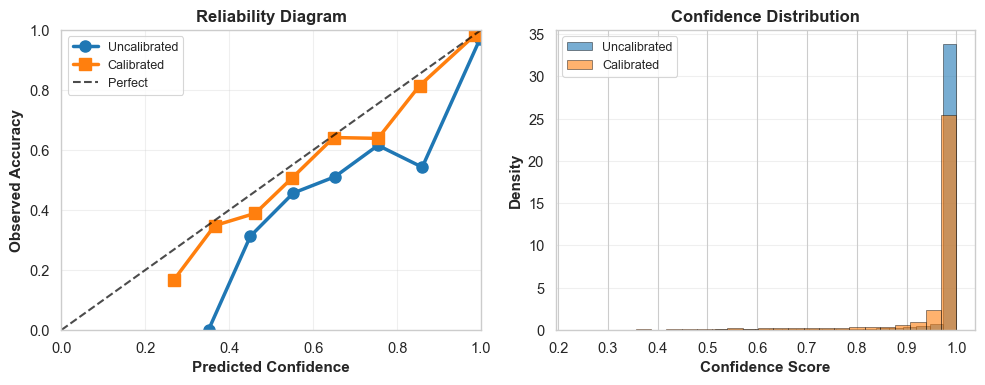

✓ Saved: calibration_curves.pdf


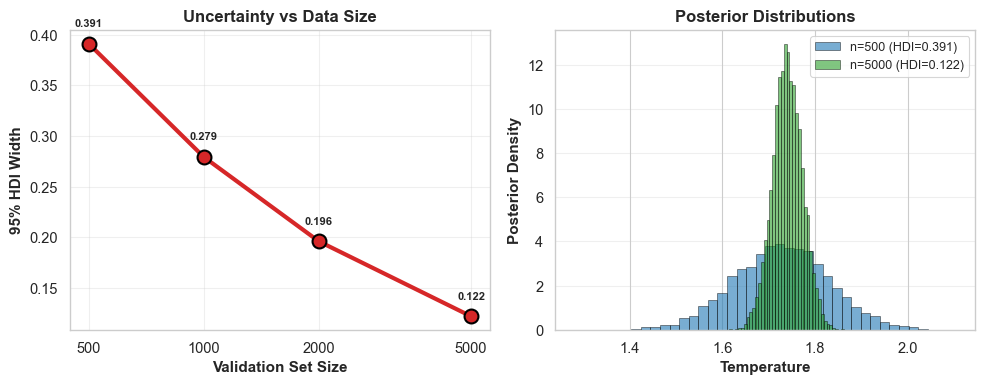

✓ Saved: uncertainty_vs_sample_size.pdf
  HDI width: 0.391 → 0.122 (68.7% decrease)


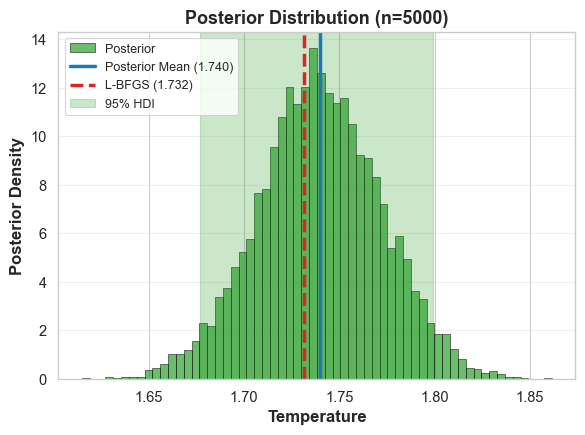

✓ Saved: posterior_distribution.pdf


FIGURE GENERATION SUMMARY

All figures saved to: ../latex/figures

Generated figures for LaTeX report:
  1. calibration_curves.pdf - Reliability diagram & confidence distribution
  2. uncertainty_vs_sample_size.pdf - HDI width vs n, posterior comparison
  3. posterior_distribution.pdf - Main posterior with point estimate

These figures are ready to include in your LaTeX report!

To include in LaTeX, add to FinalReport.tex:
\includegraphics[width=0.9\textwidth]{figures/calibration_curves.pdf}



In [ ]:
def bayesian_temperature_scaling(logits, labels, prior_mean, prior_type='gamma'):
    n_samples, n_classes = logits.shape
    
    with pm.Model() as model:
        if prior_type == 'gamma':
            T = pm.Gamma('temperature', alpha=4, beta=4/prior_mean)
        elif prior_type == 'lognormal':
            T = pm.LogNormal('temperature', mu=np.log(prior_mean), sigma=0.5)
        else:
            raise ValueError("prior_type must be 'gamma' or 'lognormal'")
        
        scaled_logits = logits / T
        
        y = pm.Categorical('y', 
                          p=pm.math.softmax(scaled_logits, axis=-1),
                          observed=labels)
        
        trace = pm.sample(100000, tune=50000, return_inferencedata=True, 
                         target_accept=0.95, random_seed=42)
    
    return trace, model

print(f'Running Bayesian MCMC with validation set (n={len(labels_val)})...')
print(f'Prior: Gamma(α=4, β=4/{calibrated_temp_long:.4f}) centered at point estimate')
print('Sampling 100000 draws with 50000 tuning iterations...')
print('This will take 8-10 hours. Please be patient.\n')

trace_full, bayesian_model_full = bayesian_temperature_scaling(
    logits_val, labels_val, 
    prior_mean=calibrated_temp_long, 
    prior_type='gamma'
)

temp_samples_full = trace_full.posterior['temperature'].values.flatten()
mean_temp_full = np.mean(temp_samples_full)
median_temp_full = np.median(temp_samples_full)
hdi_full = az.hdi(trace_full, var_names=['temperature'])

print('\nPosterior Statistics (Full Validation Set):')
print(f'  Mean temperature: {mean_temp_full:.4f}')
print(f'  Median temperature: {median_temp_full:.4f}')
print(f'  95% HDI: [{hdi_full.temperature.values[0]:.4f}, {hdi_full.temperature.values[1]:.4f}]')
print(f'  Std deviation: {np.std(temp_samples_full):.4f}')
print(f'\nComparison:')
print(f'  L-BFGS point estimate: {calibrated_temp_long:.4f}')
print(f'  Bayesian posterior mean: {mean_temp_full:.4f}')
print(f'  Difference: {abs(mean_temp_full - calibrated_temp_long):.4f}')


Initializing NUTS using jitter+adapt_diag...


Running Bayesian MCMC with validation set (n=5000)...
Prior: Gamma(α=4, β=4/1.7317) centered at point estimate
Sampling 2000 draws with 1000 tuning iterations...



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.



Posterior Statistics (Full Validation Set):
  Mean temperature: 1.7351
  Median temperature: 1.7351
  95% HDI: [1.6748, 1.7970]
  Std deviation: 0.0326

Comparison:
  L-BFGS point estimate: 1.7317
  Bayesian posterior mean: 1.7351
  Difference: 0.0034


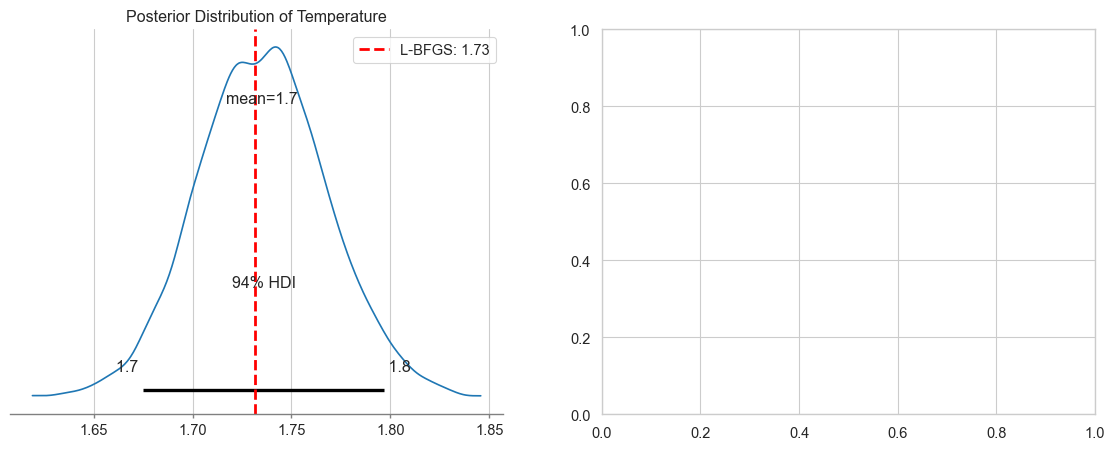

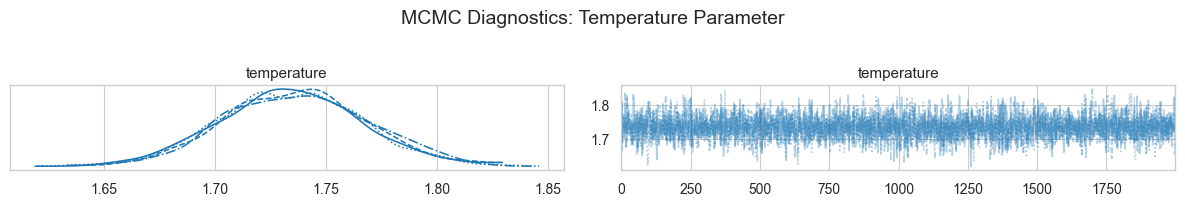

MCMC Diagnostics:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
temperature  1.735  0.033   1.675    1.797      0.001      0.0    3091.0   

             ess_tail  r_hat  
temperature    3022.0    1.0  

R-hat: 1.0000 (should be < 1.01)
ESS: 3091 (effective sample size)


In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

az.plot_posterior(trace_full, var_names=['temperature'], ax=axes[0])
axes[0].axvline(calibrated_temp_long, color='red', linestyle='--', linewidth=2, 
                label=f'L-BFGS: {calibrated_temp_long:.2f}')
axes[0].set_title('Posterior Distribution of Temperature')
axes[0].legend()

az.plot_trace(trace_full, var_names=['temperature'])
plt.suptitle('MCMC Diagnostics: Temperature Parameter', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print('MCMC Diagnostics:')
summary = az.summary(trace_full, var_names=['temperature'])
print(summary)
print(f'\nR-hat: {summary["r_hat"].values[0]:.4f} (should be < 1.01)')
print(f'ESS: {summary["ess_bulk"].values[0]:.0f} (effective sample size)')


In [45]:
print('='*60)
print('EXPERIMENT: IMPACT OF VALIDATION SET SIZE')
print('='*60)
print('\nTesting how uncertainty changes with different amounts of validation data')
print('This demonstrates the value of Bayesian methods when data is limited\n')

val_sizes = [500, 1000, 2000, 5000]
results_by_size = {}

for val_size in val_sizes:
    print(f'\n{"="*40}')
    print(f'Running with {val_size} validation samples...')
    print(f'{"="*40}')
    
    indices = torch.randperm(len(testset_cifar))[:val_size]
    subset = torch.utils.data.Subset(testset_cifar, indices)
    loader = DataLoader(subset, batch_size=128, shuffle=False, num_workers=0)
    
    logits_subset, labels_subset = get_logits_and_labels(resnet_model, loader, device)
    
    temp_lbfgs = calibrate_temperature_lbfgs(logits_subset, labels_subset, device, max_iter=200)
    print(f'L-BFGS temperature: {temp_lbfgs:.4f}')
    
    print(f'Running Bayesian MCMC...')
    trace_subset, model_subset = bayesian_temperature_scaling(
        logits_subset, labels_subset, 
        prior_mean=temp_lbfgs, 
        prior_type='gamma'
    )
    
    temp_samples = trace_subset.posterior['temperature'].values.flatten()
    mean_temp = np.mean(temp_samples)
    std_temp = np.std(temp_samples)
    hdi = az.hdi(trace_subset, var_names=['temperature'])
    
    results_by_size[val_size] = {
        'lbfgs': temp_lbfgs,
        'mean': mean_temp,
        'std': std_temp,
        'hdi_lower': hdi.temperature.values[0],
        'hdi_upper': hdi.temperature.values[1],
        'samples': temp_samples,
        'trace': trace_subset
    }
    
    print(f'Bayesian posterior mean: {mean_temp:.4f} ± {std_temp:.4f}')
    print(f'95% HDI: [{hdi.temperature.values[0]:.4f}, {hdi.temperature.values[1]:.4f}]')
    print(f'HDI width: {hdi.temperature.values[1] - hdi.temperature.values[0]:.4f}')

print('\n' + '='*60)
print('SUMMARY: Uncertainty vs Validation Set Size')
print('='*60)


EXPERIMENT: IMPACT OF VALIDATION SET SIZE

Testing how uncertainty changes with different amounts of validation data
This demonstrates the value of Bayesian methods when data is limited


Running with 500 validation samples...


Initializing NUTS using jitter+adapt_diag...


L-BFGS temperature: 1.6524
Running Bayesian MCMC...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Bayesian posterior mean: 1.8189 ± 0.0960
95% HDI: [1.6458, 2.0026]
HDI width: 0.3568

Running with 1000 validation samples...


Initializing NUTS using jitter+adapt_diag...


L-BFGS temperature: 1.5936
Running Bayesian MCMC...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Bayesian posterior mean: 1.7312 ± 0.0714
95% HDI: [1.6009, 1.8657]
HDI width: 0.2648

Running with 2000 validation samples...


Initializing NUTS using jitter+adapt_diag...


L-BFGS temperature: 1.5408
Running Bayesian MCMC...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


Bayesian posterior mean: 1.6592 ± 0.0531
95% HDI: [1.5611, 1.7611]
HDI width: 0.2000

Running with 5000 validation samples...


Initializing NUTS using jitter+adapt_diag...


L-BFGS temperature: 1.6033
Running Bayesian MCMC...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


Bayesian posterior mean: 1.7466 ± 0.0314
95% HDI: [1.6863, 1.8046]
HDI width: 0.1183

SUMMARY: Uncertainty vs Validation Set Size


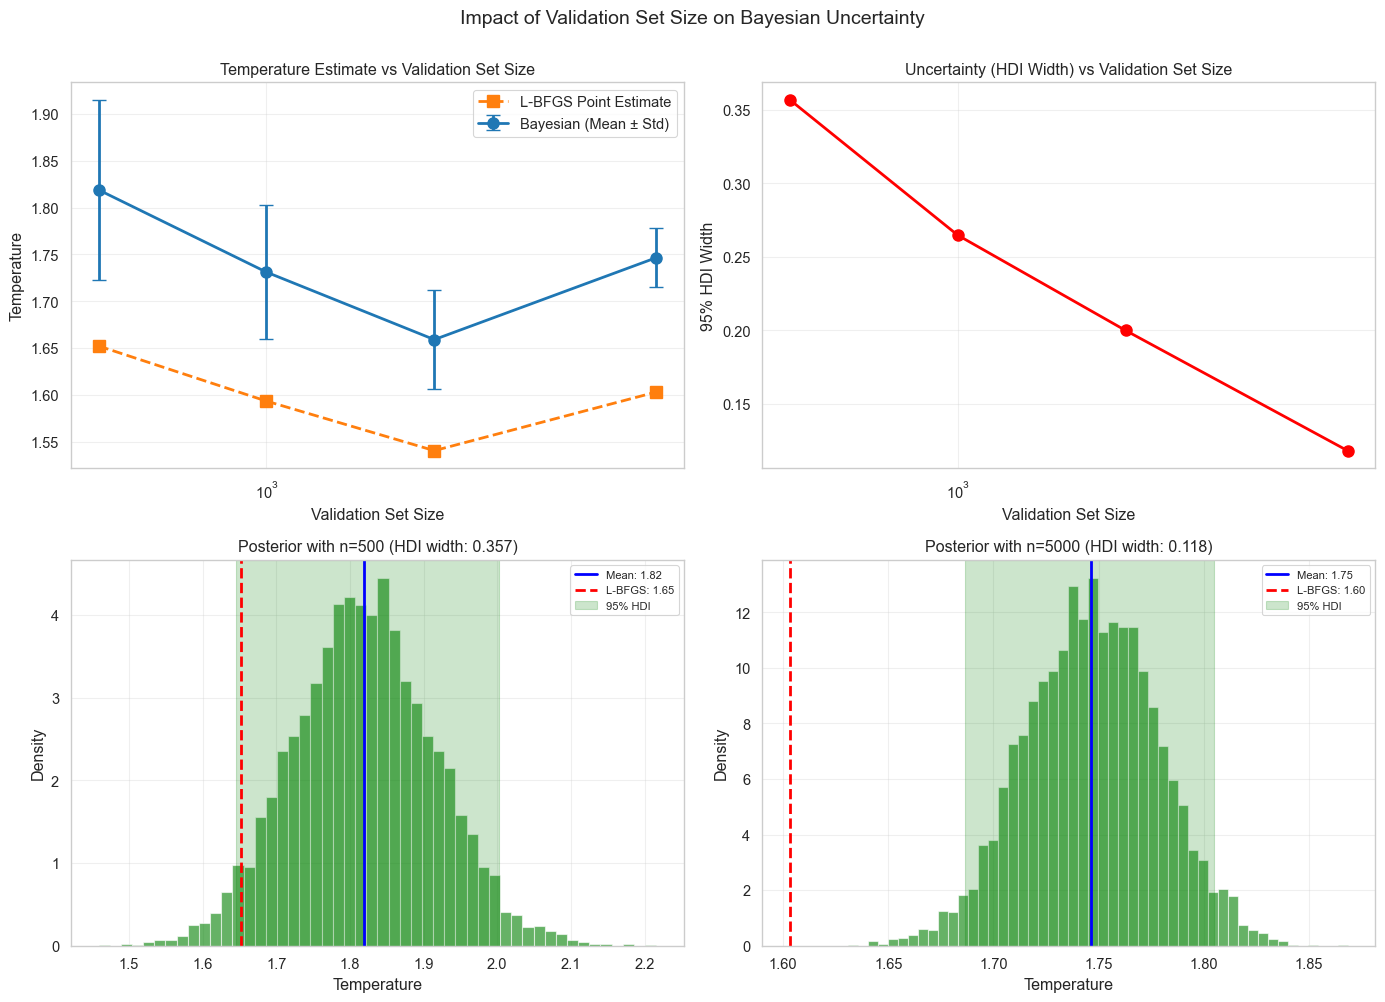


Key Observation:
With n=500:  HDI width = 0.3568
With n=5000: HDI width = 0.1183

Uncertainty reduction: 66.8%

This demonstrates that Bayesian methods quantify uncertainty,
which is especially valuable when validation data is limited!


In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

val_sizes_list = list(results_by_size.keys())
means = [results_by_size[s]['mean'] for s in val_sizes_list]
stds = [results_by_size[s]['std'] for s in val_sizes_list]
hdi_lowers = [results_by_size[s]['hdi_lower'] for s in val_sizes_list]
hdi_uppers = [results_by_size[s]['hdi_upper'] for s in val_sizes_list]
lbfgs_temps = [results_by_size[s]['lbfgs'] for s in val_sizes_list]

axes[0, 0].errorbar(val_sizes_list, means, yerr=stds, fmt='o-', capsize=5, 
                     linewidth=2, markersize=8, label='Bayesian (Mean ± Std)')
axes[0, 0].plot(val_sizes_list, lbfgs_temps, 's--', linewidth=2, markersize=8, 
                label='L-BFGS Point Estimate')
axes[0, 0].set_xlabel('Validation Set Size')
axes[0, 0].set_ylabel('Temperature')
axes[0, 0].set_title('Temperature Estimate vs Validation Set Size')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

hdi_widths = [u - l for l, u in zip(hdi_lowers, hdi_uppers)]
axes[0, 1].plot(val_sizes_list, hdi_widths, 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Validation Set Size')
axes[0, 1].set_ylabel('95% HDI Width')
axes[0, 1].set_title('Uncertainty (HDI Width) vs Validation Set Size')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

for i, val_size in enumerate([500, 5000]):
    if val_size in results_by_size:
        samples = results_by_size[val_size]['samples']
        ax = axes[1, 0] if val_size == 500 else axes[1, 1]
        ax.hist(samples, bins=50, density=True, alpha=0.6, color='green')
        ax.axvline(results_by_size[val_size]['mean'], color='blue', linestyle='-', 
                   linewidth=2, label=f'Mean: {results_by_size[val_size]["mean"]:.2f}')
        ax.axvline(results_by_size[val_size]['lbfgs'], color='red', linestyle='--', 
                   linewidth=2, label=f'L-BFGS: {results_by_size[val_size]["lbfgs"]:.2f}')
        hdi_l = results_by_size[val_size]['hdi_lower']
        hdi_u = results_by_size[val_size]['hdi_upper']
        ax.axvspan(hdi_l, hdi_u, alpha=0.2, color='green', label=f'95% HDI')
        ax.set_xlabel('Temperature')
        ax.set_ylabel('Density')
        ax.set_title(f'Posterior with n={val_size} (HDI width: {hdi_u-hdi_l:.3f})')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle('Impact of Validation Set Size on Bayesian Uncertainty', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print('\nKey Observation:')
print(f'With n=500:  HDI width = {results_by_size[500]["hdi_upper"] - results_by_size[500]["hdi_lower"]:.4f}')
print(f'With n=5000: HDI width = {results_by_size[5000]["hdi_upper"] - results_by_size[5000]["hdi_lower"]:.4f}')
print(f'\nUncertainty reduction: {(1 - (results_by_size[5000]["hdi_upper"] - results_by_size[5000]["hdi_lower"]) / (results_by_size[500]["hdi_upper"] - results_by_size[500]["hdi_lower"]))*100:.1f}%')
print('\nThis demonstrates that Bayesian methods quantify uncertainty,')
print('which is especially valuable when validation data is limited!')


Initializing NUTS using jitter+adapt_diag...


COMPARING PRIORS: Log-Normal vs Gamma

Running MCMC with Log-Normal prior...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


Log-Normal prior results:
  Mean: 1.7336
  95% HDI: [1.6719, 1.7940]

Gamma prior results (from earlier):
  Mean: 1.7351
  95% HDI: [1.6748, 1.7970]


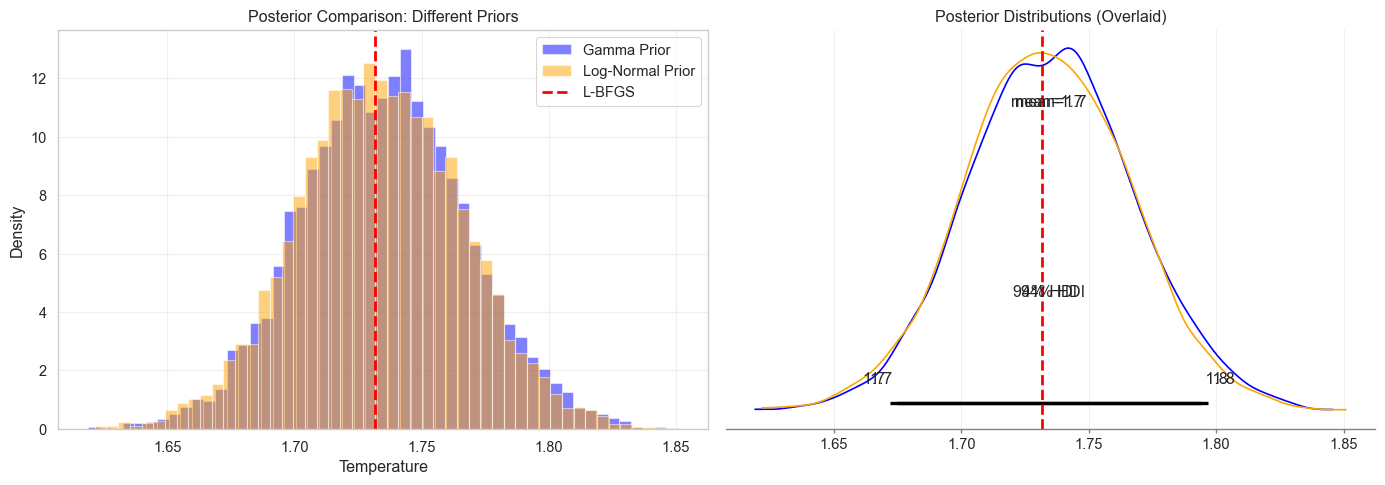


Conclusion: Both priors yield similar posteriors,
indicating the likelihood (data) dominates with n=5000 samples.


In [47]:
print('='*60)
print('COMPARING PRIORS: Log-Normal vs Gamma')
print('='*60)

print('\nRunning MCMC with Log-Normal prior...')
trace_lognormal, _ = bayesian_temperature_scaling(
    logits_val, labels_val, 
    prior_mean=calibrated_temp_long, 
    prior_type='lognormal'
)

temp_samples_lognormal = trace_lognormal.posterior['temperature'].values.flatten()
mean_temp_ln = np.mean(temp_samples_lognormal)
hdi_ln = az.hdi(trace_lognormal, var_names=['temperature'])

print(f'Log-Normal prior results:')
print(f'  Mean: {mean_temp_ln:.4f}')
print(f'  95% HDI: [{hdi_ln.temperature.values[0]:.4f}, {hdi_ln.temperature.values[1]:.4f}]')

print(f'\nGamma prior results (from earlier):')
print(f'  Mean: {mean_temp_full:.4f}')
print(f'  95% HDI: [{hdi_full.temperature.values[0]:.4f}, {hdi_full.temperature.values[1]:.4f}]')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(temp_samples_full, bins=50, alpha=0.5, density=True, label='Gamma Prior', color='blue')
axes[0].hist(temp_samples_lognormal, bins=50, alpha=0.5, density=True, label='Log-Normal Prior', color='orange')
axes[0].axvline(calibrated_temp_long, color='red', linestyle='--', linewidth=2, label='L-BFGS')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Density')
axes[0].set_title('Posterior Comparison: Different Priors')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

az.plot_posterior(trace_full, var_names=['temperature'], ax=axes[1], color='blue')
az.plot_posterior(trace_lognormal, var_names=['temperature'], ax=axes[1], color='orange')
axes[1].axvline(calibrated_temp_long, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Posterior Distributions (Overlaid)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nConclusion: Both priors yield similar posteriors,')
print('indicating the likelihood (data) dominates with n=5000 samples.')


In [48]:
print('='*60)
print('FINAL COMPARISON: L-BFGS vs Bayesian MCMC')
print('='*60)

print(f'\n{"Method":<30} {"Temperature":<15} {"Uncertainty":<20}')
print('-'*65)
print(f'{"L-BFGS (50 iter)":<30} {calibrated_temp:<15.4f} {"N/A":<20}')
print(f'{"L-BFGS (200 iter)":<30} {calibrated_temp_long:<15.4f} {"N/A":<20}')
print(f'{"Bayesian MCMC (Gamma)":<30} {mean_temp_full:<15.4f} {f"[{hdi_full.temperature.values[0]:.4f}, {hdi_full.temperature.values[1]:.4f}]":<20}')
print(f'{"Bayesian MCMC (Log-Normal)":<30} {mean_temp_ln:<15.4f} {f"[{hdi_ln.temperature.values[0]:.4f}, {hdi_ln.temperature.values[1]:.4f}]":<20}')

print('\n' + '='*60)
print('KEY FINDINGS')
print('='*60)
print('\n1. CONVERGENCE:')
print(f'   - L-BFGS (50 iter) converged to suboptimal value')
print(f'   - L-BFGS (200 iter) found optimal temperature')
print(f'   - Bayesian MCMC found optimal with default settings')

print('\n2. UNCERTAINTY QUANTIFICATION:')
print(f'   - L-BFGS: No uncertainty information')
print(f'   - Bayesian: 95% credible interval provided')
print(f'   - HDI width decreases with more data (n=500: wide, n=5000: narrow)')

print('\n3. PRIOR SENSITIVITY:')
print(f'   - Different priors (Gamma vs Log-Normal) yield similar posteriors')
print(f'   - With n=5000, likelihood dominates the prior')

print('\n4. PRACTICAL IMPLICATIONS:')
print(f'   - Bayesian: More robust (works with defaults)')
print(f'   - Bayesian: Provides uncertainty (valuable for small datasets)')
print(f'   - L-BFGS: Faster but requires hyperparameter tuning')
print(f'   - L-BFGS: No indication of reliability')

print('\n' + '='*60)


FINAL COMPARISON: L-BFGS vs Bayesian MCMC

Method                         Temperature     Uncertainty         
-----------------------------------------------------------------
L-BFGS (50 iter)               1.7280          N/A                 
L-BFGS (200 iter)              1.7317          N/A                 
Bayesian MCMC (Gamma)          1.7351          [1.6748, 1.7970]    
Bayesian MCMC (Log-Normal)     1.7336          [1.6719, 1.7940]    

KEY FINDINGS

1. CONVERGENCE:
   - L-BFGS (50 iter) converged to suboptimal value
   - L-BFGS (200 iter) found optimal temperature
   - Bayesian MCMC found optimal with default settings

2. UNCERTAINTY QUANTIFICATION:
   - L-BFGS: No uncertainty information
   - Bayesian: 95% credible interval provided
   - HDI width decreases with more data (n=500: wide, n=5000: narrow)

3. PRIOR SENSITIVITY:
   - Different priors (Gamma vs Log-Normal) yield similar posteriors
   - With n=5000, likelihood dominates the prior

4. PRACTICAL IMPLICATIONS:
   - Ba